# **Housing Prices Prediction Model**

### Predicting Housing prices in the state of california
* Download and Process the data
  * Download the data
  * Get an overview with the describe function
* Split the data into two subsets : Train and Test
* Discover and Visualise the Data to Gain Insights
  * Look for correlations and geographical data
  * Experiment with different attribute combinations 
* Prepare the data for the machine learning algorithms
  * Data cleaning
  * Feature Scaling
* Select and Train a suitable model
* Fine-tune the model
  * Grid Search
  * Randomised Search
  * Ensemble Methods
* Launch, Monitor & Maintain Your System
  * Deployment
  * Maintenance

In [2]:
import os
import tarfile
import urllib.request

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import sklearn
assert sklearn.__version__ >= "0.20"

# **Create a Test and Train dataset**

In [3]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)


fetch_housing_data()
housing = load_housing_data()
housing.head()
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


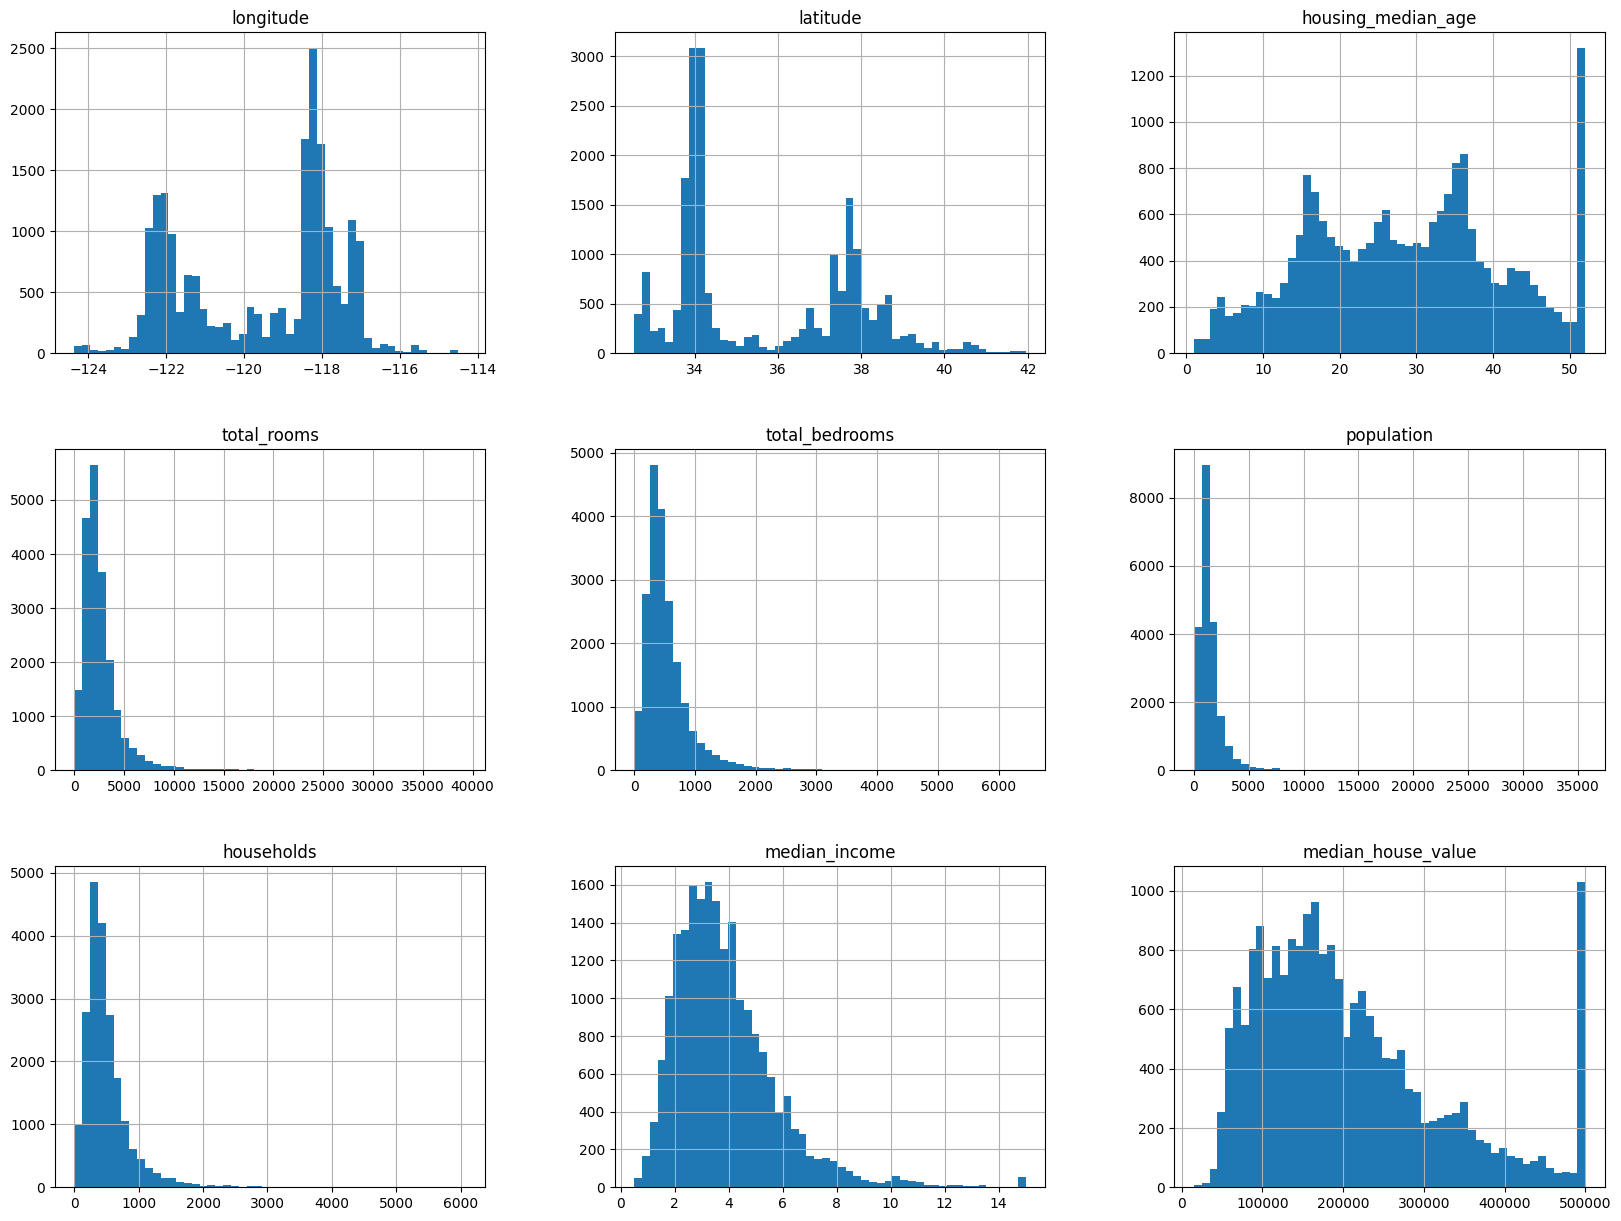

In [4]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

In [5]:
# Set a constant seed so that the train and test set are always identical on every run
from zlib import crc32


np.random.seed(42)

# For illustration only. Scikt-Learn has train_test_split()
def split_test_train(data, test_ratio): # take input of the data and the test_split ratio
          shuffled_indices = np.random.permutation(len(data)) # shuffle the data permutation based on the length of the data
          test_set_size = int(len(data) * test_ratio) # calculate the number of instances to include in test set
          test_indices = shuffled_indices[:test_set_size] # select the first portion of the data for test data
          train_indices = shuffled_indices[test_set_size:] # select the rest of portion for train data
          return data.iloc[train_indices], data.iloc[test_indices] # return the data in iloc form for access of rows by index

# We can also split the data into test and train by ID
# Also ensure that each instance has unqique and immutable identifier, so split remains stable even when dataset changes

def test_set_check(identifier, test_ratio):
          # convert identifier into 64-bit int, apply crc32 hash, compare against threshold
          return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

# Function to split the dataset into train and test sets using stable ID-based hashing
def split_test_train_by_id(data, test_ratio, id_column):
          # Extract the identifier column from the dataset
          ids = data[id_column]
          
          # Apply the test_set_check to each identifier to decide if it's in the test test
          in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))

          # returns two datasets :
          # - Test set : rows where in_test_set is True
          # - Training set : rows where in_test_set is False
          return data.loc[~in_test_set], data.loc[in_test_set]

In [6]:
# Reset the index column, perform a train_test split and create a new more stable index ID column
# Perform train-test split again with the new 'id' based on geo-coordinates


# Reset the index of the DF so that new column can be named "index"
housing_with_id = housing.reset_index()

# Perform a train-test split using the 'index' column as the ID
# simple, quick solution for stable splits only if database wont change
train_set, test_set = split_test_train_by_id(housing_with_id, 0.2, "index")

# Create a new more stable ID based on lat and long coords
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]

# Perform another train-test split using 'id' column based on geo-coordinates
# more robust solution that uses the data's inherent
train_set, test_set = split_test_train_by_id(housing_with_id, 0.2, "id")

# Quick overview of data
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
59,59,-122.29,37.82,2.0,158.0,43.0,94.0,57.0,2.5625,60000.0,NEAR BAY,-122252.18
60,60,-122.29,37.83,52.0,1121.0,211.0,554.0,187.0,3.3929,75700.0,NEAR BAY,-122252.17
61,61,-122.29,37.82,49.0,135.0,29.0,86.0,23.0,6.1183,75000.0,NEAR BAY,-122252.18
62,62,-122.29,37.81,50.0,760.0,190.0,377.0,122.0,0.9011,86100.0,NEAR BAY,-122252.19
67,67,-122.29,37.80,52.0,1027.0,244.0,492.0,147.0,2.6094,81300.0,NEAR BAY,-122252.20


income_cat
3    7236
2    6581
4    3639
5    2362
1     822
Name: count, dtype: int64

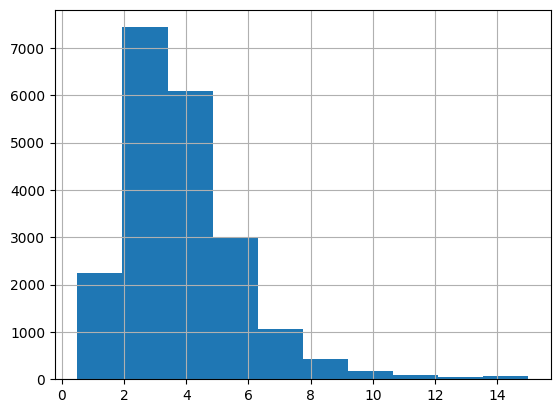

In [7]:
# Now using the Sklearn library for train-test split and Stratified Shuffle Split

from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

housing["median_income"].hist()

# Create a new categorical column 'income_cat' by binning 'median_income' into discrete categories
# Binning is when the continuous variable is broken down into discrete groups or categories to help with analysis and enable stratified sampling
housing["income_cat"] = pd.cut(housing["median_income"], # continuous variable to be binned
                              bins=[0., 1.5, 3.0, 4.5, 6., np.inf], # edges of the bins (intervals)
                              labels=[1, 2, 3, 4, 5]) # labels assigned to each bin to represent income categories

housing["income_cat"].value_counts()


<Axes: >

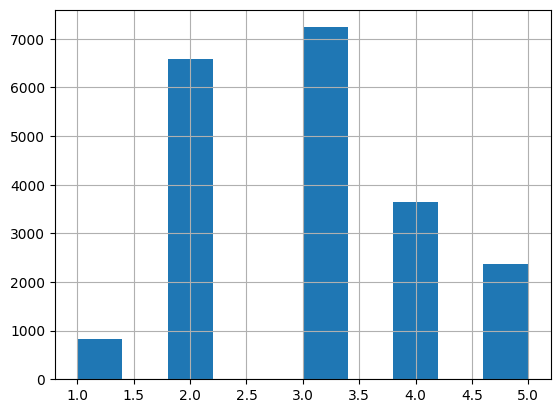

In [8]:
housing["income_cat"].hist()

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

# Perform a stratified split on the housing data where only 20% of the data is used for the training
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Performs the split and maintains the income_cat distribution
for train_index, test_index in split.split(housing, housing["income_cat"]):
          strat_train_set = housing.loc[train_index] # Get training rows by index
          strat_test_set = housing.loc[test_index] # Get test rows by index

# Calculate the proportion of each income catgeory in the stratified test set
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

# Calculates the proportions of each income category in full dataset
housing["income_cat"].value_counts() / len(housing)

income_cat
3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: count, dtype: float64

In [10]:
# Helper function to calculate income category proportions for any dataset
def income_cat_proportions(data):
          return data["income_cat"].value_counts() / len(data)

# Perform a random train-test split without stratification
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)



compare_props = pd.DataFrame({
          "Overall": income_cat_proportions(housing),
          "Stratified": income_cat_proportions(strat_test_set),
          "Random": income_cat_proportions(test_set),
}).sort_index()

compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
income_cat,,,,,
1,0.039826,0.039971,0.040213,0.973236,0.364964
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114341,0.109496,-4.318374,-0.084674


# **Discover and Visualise the Data to Gain Insights**

NameError: name 'save_fig' is not defined

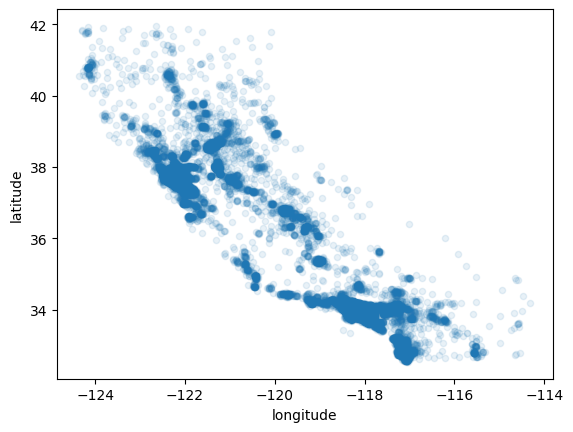

In [12]:
housing = strat_train_set.copy() # Make a copy of the data

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
save_fig("geographical_visuals")